Hace falta algo que indique con qué entorno vamos a trabajar

Importar lo que hace falta

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re 

In [2]:
data_url = "../Data/properatti.csv"

In [3]:
data = pd.read_csv(data_url, encoding="utf-8")

In [4]:
#limpiamos los que NaN en el precio
data = data.dropna(axis=0, how='any', subset=['price_aprox_usd'])

In [5]:
data_clean=data

In [6]:

def regex_to_ones(col, reg, fill = 0) :
    """Returns a series with ones or other value result of apply the regular expresion to the column
    the value of one will be when the regular expression search() method found a match
    the fill value (default to 0) will be when the regolar expression serach() metcho did not found a match
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : 1 if x is not None else fill)
   
    return serie

In [7]:
_pattern = 'cochera|garage|auto'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_ones(data_clean['description'], _express)
data_clean['cochera'] = work

In [8]:
_pattern = 'piscina|pileta'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_ones(data_clean['description'], _express)
data_clean['pileta'] = work

In [9]:
_pattern = 'parrilla'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_ones(data_clean['description'], _express)
data_clean['parrilla'] = work

In [10]:
_pattern = 'balcon'
_express = re.compile(_pattern, flags = re.IGNORECASE)

work = regex_to_ones(data_clean['description'], _express)
data_clean['balcon'] = work

In [65]:
# Crear una categoría númerica (en base 2) de acuerdo a los valores individuales (es dependiente de la posición)

data_clean['amenities'] = data_clean['cochera']*4 + data_clean['pileta']*3 + data_clean['parrilla']*1 + data_clean['balcon']*1

#Mejor correlacion hasta ahora: 0.76, con puntajes
#cochera: 4
#pileta: 3
#parrilla: 1
#balcon: 1
#cuantiles: 0.8, 0.5


In [66]:
puntaje_alto_depto= data_clean['amenities'].quantile(0.8)
puntaje_medio_depto=data_clean['amenities'].quantile(0.5)

print(puntaje_medio_depto,puntaje_alto_depto)

def my_func(x):    
    if x['property_type']=='apartment':
        if x['amenities']>puntaje_alto_depto:
            return '3_alto_depto'
        elif x['amenities']>puntaje_medio_depto:
                return '2_medio_depto'
        else: 
            return '1_bajo_depto'
            
    else:
        return x['property_type']
    
    
data_clean['property_type_2'] = data_clean.apply(my_func, axis=1)


4.0 5.0


In [67]:
#funcion para borrar outliers.
def borrar_outliers(data, columnas):
    """Solo recibo columnas con valores numericos. 
    Las columns van en forma de tupla"""
    cols_limpiar = columnas
    mask=np.ones(shape=(data.shape[0]), dtype=bool)

    for i in cols_limpiar:
        
        #calculamos cuartiles, y valores de corte
        Q1=data[i].quantile(0.25)
        Q3=data[i].quantile(0.75)
        RSI=Q3-Q1
        max_value=Q3+1.5*RSI
        min_value=Q1-1.5*RSI
        
        #ajusto el min value a mano... no puede ser negativo.
        min_value=max(data[i].quantile(0.05), min_value)
        
        #filtramos por max y min
        mask=np.logical_and(mask, np.logical_and(data[i]>=min_value, data[i]<=max_value))
    return data[mask]

In [68]:
def check_corr(data, place, tipo, outliers):
    """place indica filtro por lugar para ver correlacion
    tipo indica filtro por tipo de propierdad para ver la correlacion
    *outliers muestra las variables donde vamos a limpiar valores extremos (es una tupla)"""
    
    data_place = data[data.place_name==place]
    data_tipo = data_place[data_place.property_type_2==tipo]

    data_outliers = borrar_outliers(data_tipo, outliers)
    
    
    #sns.scatterplot(x=data_outliers['surface_total_in_m2'], y=data_outliers['price_aprox_usd'])
    
    corr = data_outliers[[outliers[0], outliers[1]]].corr()
    return corr.iloc[0,1]
    
    


In [69]:
#hacemos las iteraciones para place y para tipo. Elijo arbitrariamente cuanto quiero mostrar. 
#elijo los que tienen mas valores, y despues les paso un index para que solo me muestre el nombre del lugar
iterar_place=data_clean['place_name'].value_counts().head(10)
iterar_place = iterar_place.index

iterar_tipo=data_clean['property_type_2'].value_counts().head(4)
iterar_tipo = iterar_tipo.index
order=iterar_tipo.argsort()
iterar_tipo=iterar_tipo[order]

In [70]:
#--------------------------------------------------------------------#
#En el TP01.04 decidimos usar la superficie cubierta
#--------------------------------------------------------------------#

In [71]:
corr_surf_covered=[]
for tipo in iterar_tipo:
    for place in iterar_place:
        
        #Formato para que sea legible (no aporta mucho al calculo)
        spaces= " "*(16-len(place))
        mask_conteo = np.logical_and(data_clean['place_name']==place, data_clean['property_type_2']==tipo)
        conteo= data_clean[ mask_conteo].shape[0]
        
        #Esta es la importante
        correlacion = round(check_corr(data_clean, place, tipo, ('price_aprox_usd', 'surface_covered_in_m2')), 2)
        
        #mMostrar resultado
#         print(f' Lugar: {place} {spaces} \t // Tipo: {tipo} \t \t //corr: {correlacion} \t // conteo: {conteo}')
        
        if conteo > 100:
            corr_surf_covered.append(correlacion)

In [72]:
pd.Series(corr_surf_covered).mean()

0.7594117647058822

In [73]:
#--------------------------------------------------------------------#

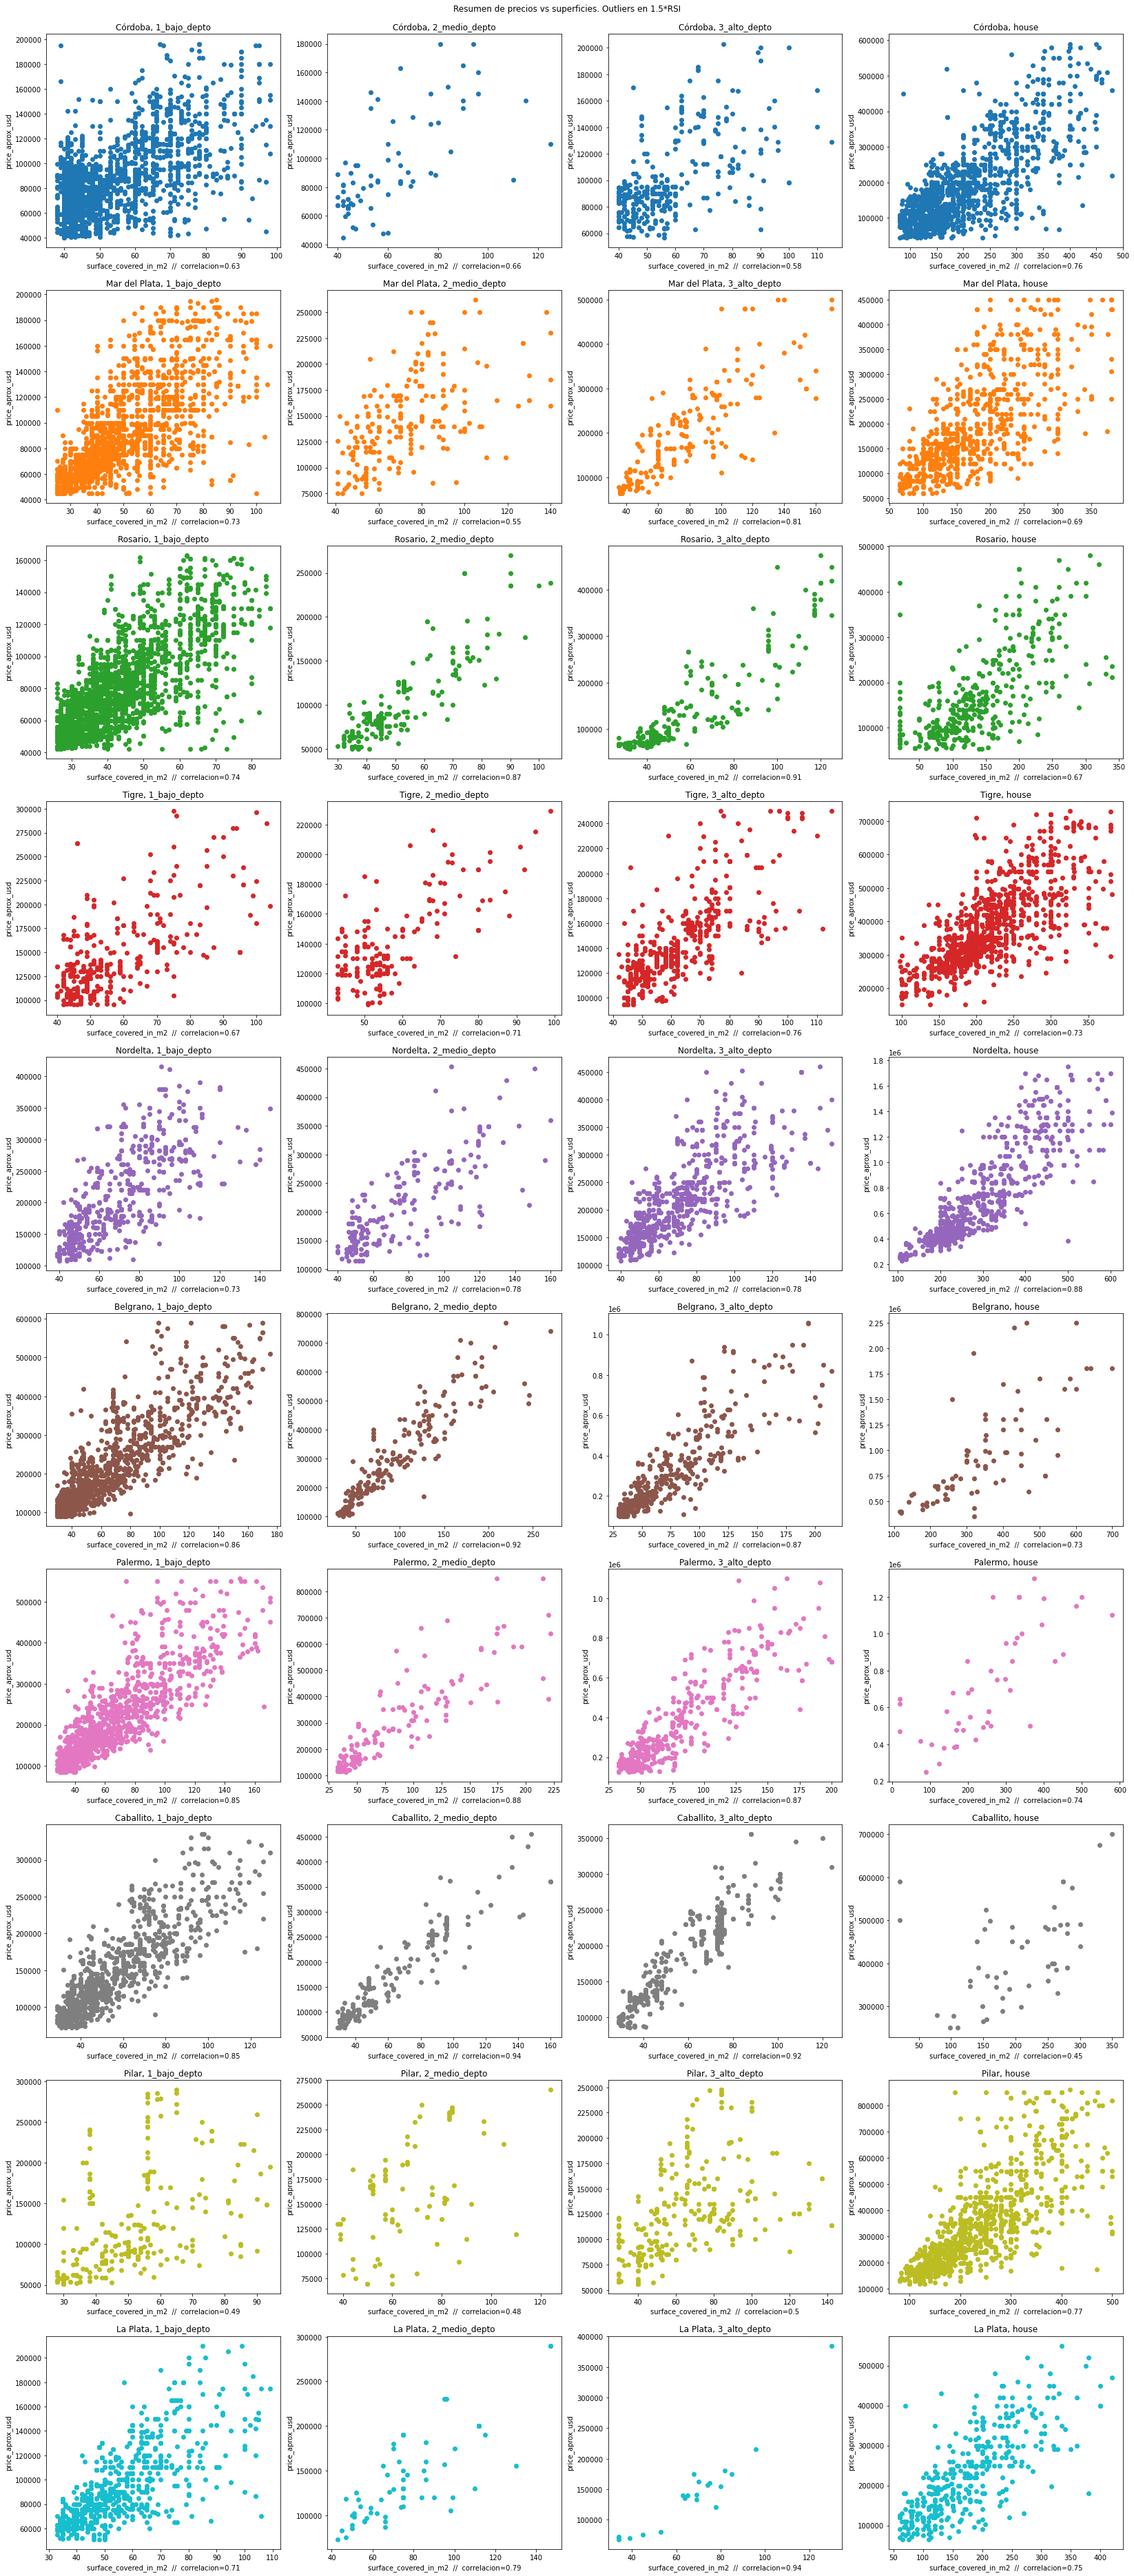

In [77]:
#Vamos a plotear, separando por groupby el data_clean

#levanto el subplot

len_tipo=len(iterar_tipo)
len_place=len(iterar_place)
fig, axs = plt.subplots(len_place,len_tipo, figsize=(7*len_tipo,6*len_place), facecolor=(1, 1, 1))

#mapa de colores para que diferenciar por place
color_map=('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
            '#17becf', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
            '#bcbd22', '#17becf')

#esto es el titulo
fig.suptitle(t="Resumen de precios vs superficies. Outliers en 1.5*RSI")

#posicion relativa de los graficos, para que no se vean tan apretados.
fig.subplots_adjust(top=0.97)

#Un "j" para cada tipo
j=0 
for tipo in iterar_tipo:
    
    #Un "i" para cada place
    i=0
    for place in iterar_place:
        #reducimos para sacar todo lo que no nos sirve.
        data_reducida = data_clean.loc[:, ['place_name', 'price_aprox_usd', 'surface_covered_in_m2', 'property_type_2']]
        
        #agrupamos la data. filtrando por cada place.
        data_grouped = data_reducida.groupby(by = 'place_name').filter(lambda x: all(x['place_name']==place))

        #volvemos a agrupar la data. filtrando por cada tipo.
        data_grouped = data_grouped.groupby(by = 'property_type_2').filter(lambda x: all(x['property_type_2']==tipo))
        
        #separo por amenities
        
        #aplico el filtro de ouliers para cada grupo
        data_grouped = borrar_outliers(data_grouped, ('price_aprox_usd','surface_covered_in_m2'))
        
        
        #calculo corr para meter en el grafico (si, esto no deberia estar aca... sacar, eventualmente)
        corr_grafico =  data_grouped[['surface_covered_in_m2', 'price_aprox_usd']].corr()
        corr_grafico =  corr_grafico.iloc[0,1]
        corr_grafico = round(corr_grafico, 2)

        #seteo las condiciones para cada axs[i,j]
        axs[i,j].set_title(f'{place}, {tipo}')
        axs[i,j].set_xlabel(f'surface_covered_in_m2  //  correlacion={corr_grafico}')
        axs[i,j].set_ylabel('price_aprox_usd')
        axs[i,j].scatter( x=data_grouped['surface_covered_in_m2'], y=data_grouped['price_aprox_usd'], c=color_map[i])

        #vamos al siguiente place. Muevo hacia abajo en el plot
        i+=1
    #vamos a siguiente tipo Muevo hacia la derecha en el plot
    j+=1

In [78]:
fig.savefig('scatter separado por tipo depto')

Text(0.5, 1.0, 'hola')

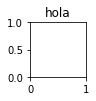

In [75]:
fig, axs = plt.subplots(1,1, figsize=(1,1), facecolor=(1, 1, 1), sharey='row')
axs.set_title('hola')

C:\Users\IVANMO~1\AppData\Local\Temp/ipykernel_18100/476453246.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(data_boxplot.keys())
C:\Users\IVANMO~1\AppData\Local\Temp/ipykernel_18100/476453246.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(data_boxplot.keys())
C:\Users\IVANMO~1\AppData\Local\Temp/ipykernel_18100/476453246.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(data_boxplot.keys())
C:\Users\IVANMO~1\AppData\Local\Temp/ipykernel_18100/476453246.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(data_boxplot.keys())
C:\Users\IVANMO~1\AppData\Local\Temp/ipykernel_18100/476453246.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[j].set_xticklabels(data_boxplot.keys())
C:\Users\IVANMO~1\AppData\Local\Temp/ipykerne

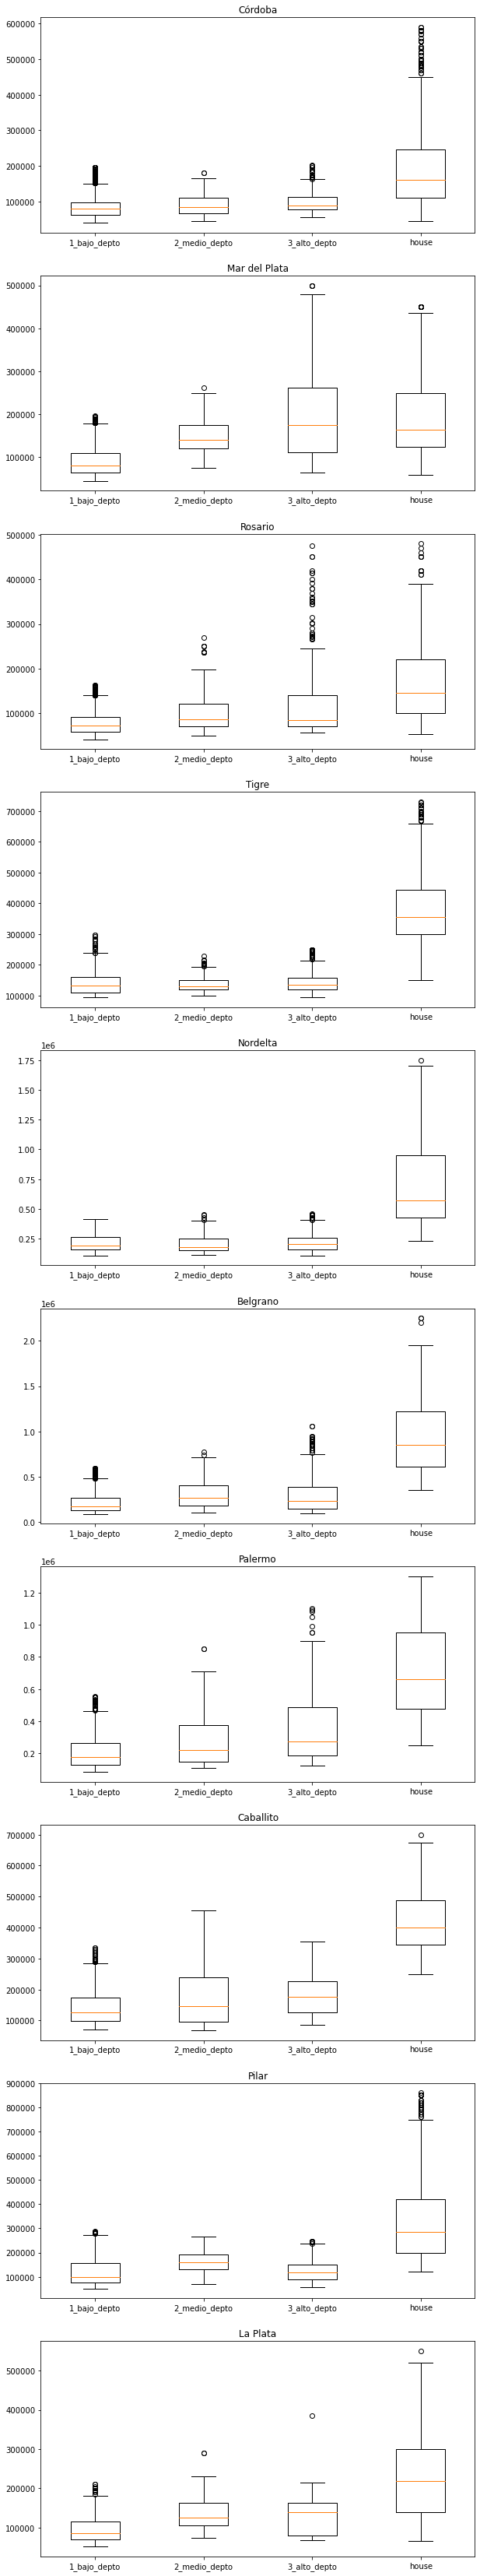

In [80]:
#Vamos a plotear, separando por groupby el data_clean

#levanto el subplot. OJO, solo voy a hacer un plot por cada place
len_tipo=len(iterar_tipo)
len_place=len(iterar_place)
fig, axs = plt.subplots(len_place,1, figsize=(10,6*len_place), facecolor=(1, 1, 1), sharey='row')

#Un "j" para cada lugar 
j=0 
for place in iterar_place:
    
    #reducimos para sacar todo lo que no nos sirve.
    data_reducida = data_clean.loc[:, ['place_name', 'price_aprox_usd', 'surface_covered_in_m2', 'property_type_2']]

    #agrupamos la data. filtrando por cada place.
    data_grouped = data_reducida.groupby(by = 'place_name').filter(lambda x: all(x['place_name']==place))

    #hacemos un diccionario por cada tipo, dentro de cada place.
    
    #diccionario vacio para poder empezar. Despues iteramos por tipo, y nos metemos dentro de un nuevo dataframe
    #que despues vamos a usar para graficar.
    data_boxplot={}
    for i in iterar_tipo:
        data_temp = data_grouped.groupby(by = 'property_type_2').filter(lambda x: all(x['property_type_2']==i))
        data_temp = borrar_outliers(data_temp, ('price_aprox_usd','surface_covered_in_m2'))
        data_boxplot[i]=list(data_temp['price_aprox_usd'])
        
    #seteo las condiciones para cada axs[i,j]. PLoteo por el nuevo df. Esto tira unos warnings que no supe como eliminar.
    axs[j].set_title(place)
    axs[j].set_xticklabels(data_boxplot.keys())
    axs[j].boxplot( x=data_boxplot.values())

    
    #vamos a siguiente tipo Muevo hacia abajo en el plot
    j+=1

In [81]:
fig.savefig('boxplot separado por tipo depto')